In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'state-farm-distracted-driver-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5048%2F868335%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T145512Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D97231df502eb65d638de92c886b6a5a86b52c6459ecb451ba354135f6ba12f6389316bed00552e7fea349853773a389922763b7eeefa8f60e051bdac309f8adaacd5a5e735f73bf1b4eb31398b02a931ddf5ff4bd400ea051cbcf12dd7c5252475ec8865bc3036b245dbae992c0b7ffea7dc91a3e50f2aa8ad128825e09ee27b159c9d41fe0206179d3ad25e69fbac16e9d1d3ca6a3a72927a1884fdcdd6f16ac2db918bcdeb41bac5fae0fe62ac0bf68ab4b59aa9c8e325248a61c3baaa98b9773e77feeee5aebb6b285f6ad2c36a2db6eed5cb942bf86215a7277a30e23d5b481d4382cce0f3845afbd52406c311f22759bbfff580659ced64d63913c6c2aa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4296022692 bytes downloaded
Downloaded and uncompressed: state-farm-distracted-driver-detection
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Rescaling,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# converting data into train data from image generator
train_data = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100),
  batch_size=128,label_mode='categorical',)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.


In [ ]:
# converting data into validation data from image generator
val_data = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=128,label_mode='categorical',)

Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


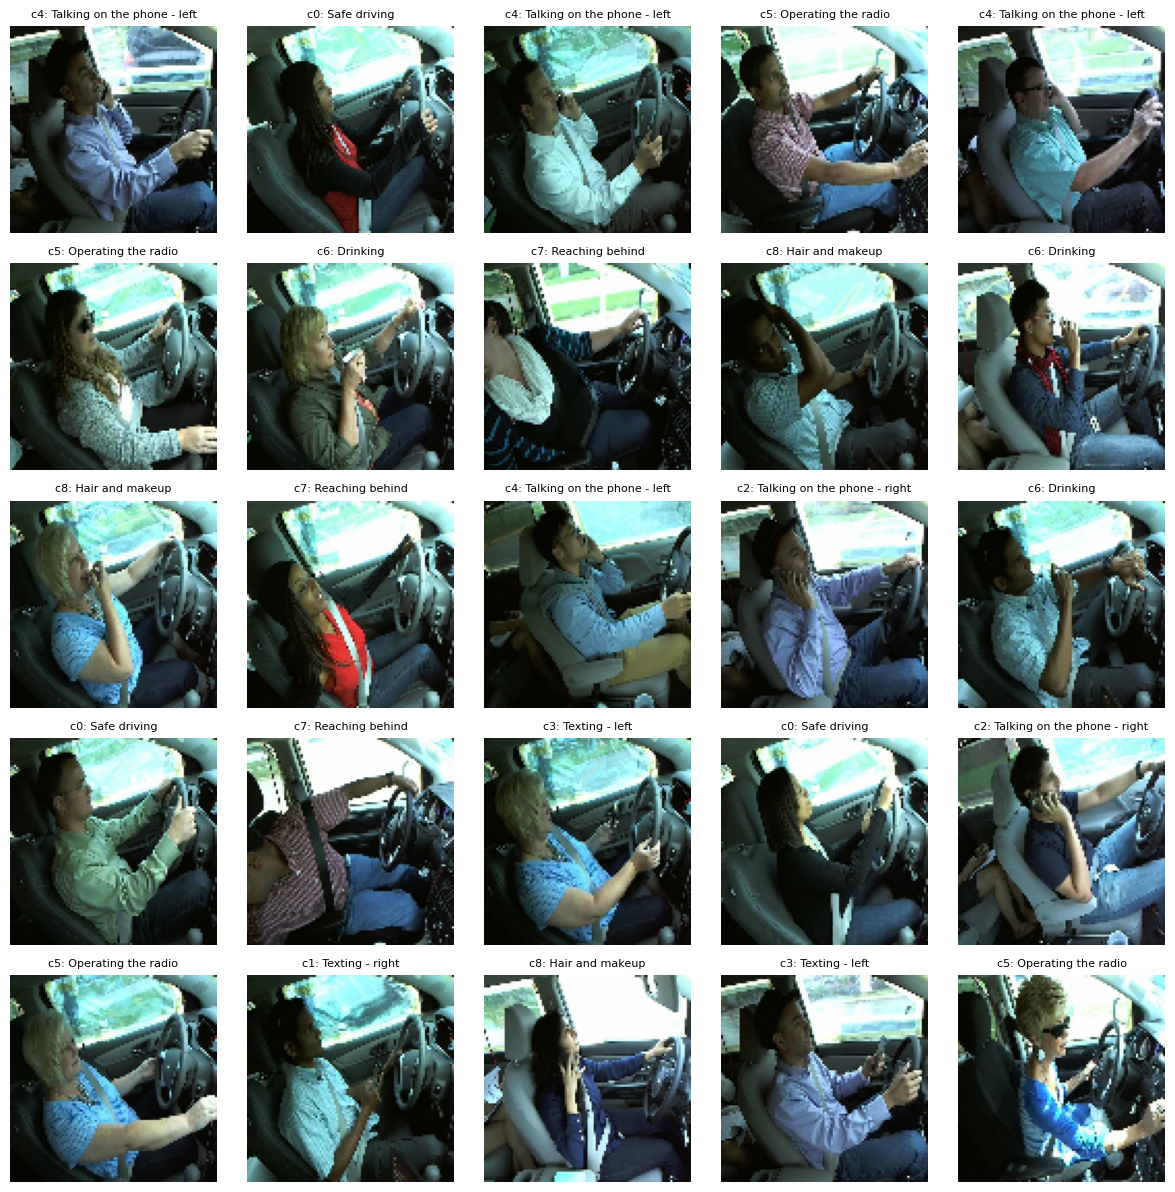

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

map = {'c0': 'Safe driving',
      'c1': 'Texting - right',
      'c2': 'Talking on the phone - right',
      'c3': 'Texting - left',
      'c4': 'Talking on the phone - left',
      'c5': 'Operating the radio',
      'c6': 'Drinking',
      'c7': 'Reaching behind',
      'c8': 'Hair and makeup',
      'c9': 'Talking to passenger'}
plt.figure(figsize=(12,12))
for images, labels in train_data.take(1):
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        original_class = f'c{labels[i]}'  # Original class label
        activity_name = map[original_class]  # Corresponding activity name
        plt.title(f'{original_class}: {activity_name}', fontsize=8)  # Title with both original class and activity name
        plt.axis("off")
plt.tight_layout(pad=1.0)
plt.show()


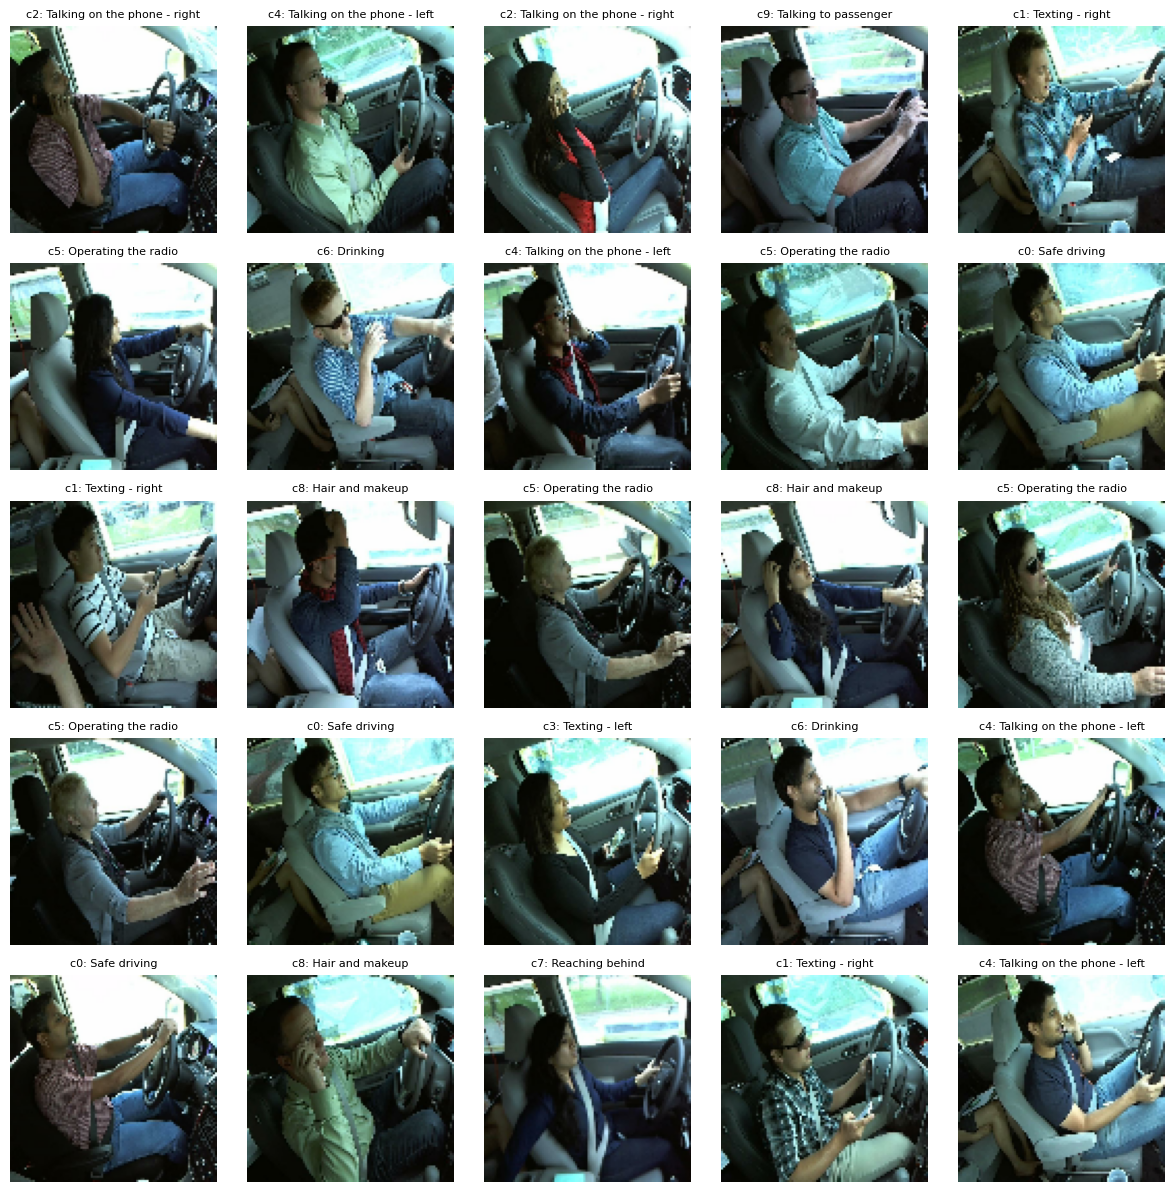

In [ ]:
map = {'c0': 'Safe driving',
      'c1': 'Texting - right',
      'c2': 'Talking on the phone - right',
      'c3': 'Texting - left',
      'c4': 'Talking on the phone - left',
      'c5': 'Operating the radio',
      'c6': 'Drinking',
      'c7': 'Reaching behind',
      'c8': 'Hair and makeup',
      'c9': 'Talking to passenger'}
plt.figure(figsize=(12,12))

for images, labels in val_data.take(1):
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        original_class = f'c{labels[i]}'  # Original class label
        activity_name = map[original_class]  # Corresponding activity name
        plt.title(f'{original_class}: {activity_name}', fontsize=8)  # Title with both original class and activity name
        plt.axis("off")

plt.tight_layout(pad=1.0)
plt.show()

Do not run this, less accuracy

In [ ]:
# creating our model
'''
model = tf.keras.models.Sequential([
    Rescaling(scale = 1/255,input_shape=(100,100,3)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    Flatten(),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(512,activation='relu'),
    Dropout(0.1),
    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(10,activation='softmax'),
])

# compiling our model
model.compile(optimizer = Adam(learning_rate=0.01),loss = 'categorical_crossentropy',metrics=['acc'])
model.summary()

In [ ]:
# creating our model
'''
model = tf.keras.models.Sequential([
    Rescaling(scale = 1/255,input_shape=(100,100,3)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(512,activation='relu'),

    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(10,activation='softmax'),
])

# compiling our model
model.compile(optimizer = Adam(learning_rate=0.01),loss = 'categorical_crossentropy',metrics=['acc'])
model.summary()

In [ ]:
model = tf.keras.models.Sequential([
    Rescaling(scale=1/255, input_shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                 

In [ ]:
'''
model = tf.keras.models.Sequential([
    Rescaling(scale=1/255, input_shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_211 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_212 (Conv2D)         (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                

In [ ]:
model = tf.keras.models.Sequential([
      Rescaling(scale=1/255, input_shape=(100, 100, 3)),
      Conv2D(16, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(1024, activation='relu'),
      Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer= Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 49, 49, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)       

In [ ]:
es = EarlyStopping(monitor='val_accuracy',min_delta=0.03,patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(train_data,epochs=5,validation_data=val_data,callbacks=[es])
#history = model.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/5
141/141 [==============================] - 36s 219ms/step - loss: 0.9267 - accuracy: 0.6935 - val_loss: 0.1801 - val_accuracy: 0.9532
Epoch 2/5
141/141 [==============================] - 33s 223ms/step - loss: 0.1017 - accuracy: 0.9735 - val_loss: 0.0861 - val_accuracy: 0.9766
Epoch 3/5
141/141 [==============================] - 30s 203ms/step - loss: 0.0366 - accuracy: 0.9895 - val_loss: 0.0682 - val_accuracy: 0.9788
Epoch 4/5
141/141 [==============================] - 35s 240ms/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 0.0402 - val_accuracy: 0.9895
Epoch 5/5
141/141 [==============================] - 31s 208ms/step - loss: 0.0146 - accuracy: 0.9956 - val_loss: 0.0429 - val_accuracy: 0.9873


In [ ]:
'''
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[es])

Epoch 1/10
141/141 [==============================] - 37s 253ms/step - loss: 1.9419 - accuracy: 0.3043 - val_loss: 0.8052 - val_accuracy: 0.8091
Epoch 2/10
141/141 [==============================] - 35s 242ms/step - loss: 0.5631 - accuracy: 0.8222 - val_loss: 0.1518 - val_accuracy: 0.9661
Epoch 3/10
141/141 [==============================] - 38s 259ms/step - loss: 0.2413 - accuracy: 0.9266 - val_loss: 0.0650 - val_accuracy: 0.9828
Epoch 4/10
141/141 [==============================] - 39s 266ms/step - loss: 0.1575 - accuracy: 0.9501 - val_loss: 0.0400 - val_accuracy: 0.9884
Epoch 5/10
141/141 [==============================] - 35s 242ms/step - loss: 0.1338 - accuracy: 0.9585 - val_loss: 0.0360 - val_accuracy: 0.9902
Epoch 6/10
141/141 [==============================] - 35s 242ms/step - loss: 0.0975 - accuracy: 0.9687 - val_loss: 0.0322 - val_accuracy: 0.9904
Epoch 7/10
141/141 [==============================] - 35s 242ms/step - loss: 0.0819 - accuracy: 0.9746 - val_loss: 0.0261 - val_ac

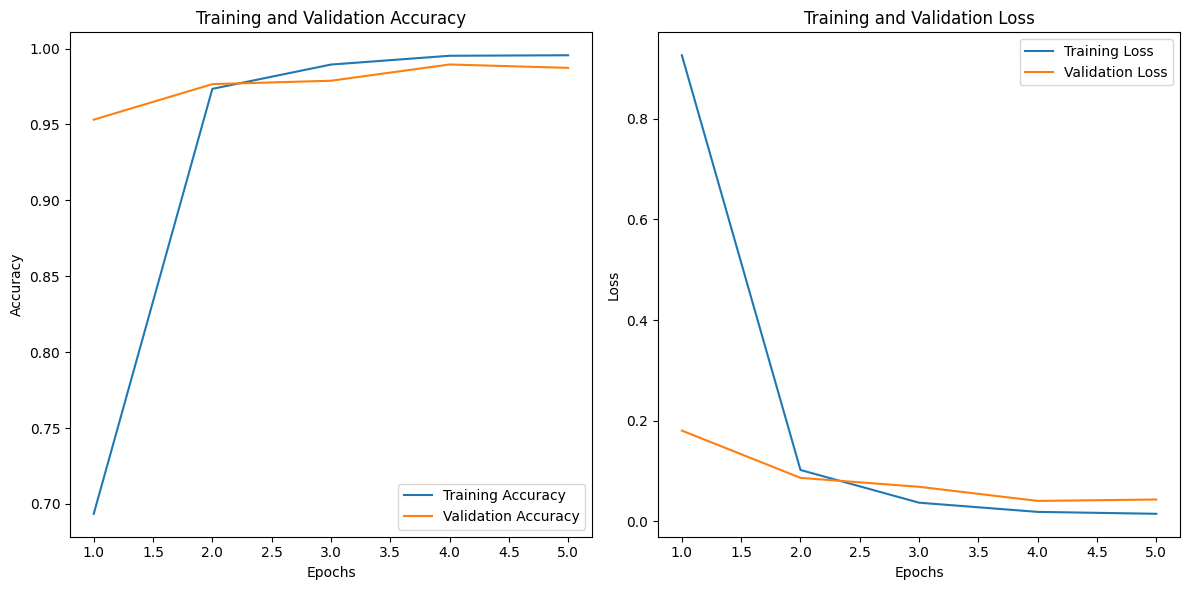

In [ ]:
# visualizing accuracy and losses

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# converting training data from image generator for prediction
test_data = image_dataset_from_directory(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    batch_size = 32,
    image_size=(100,100),
    labels = None,
    label_mode=None,
    shuffle = False
)

Found 79726 files belonging to 1 classes.


In [ ]:
# function for predicting images

def predict_image(path):
    img = tf.keras.utils.load_img(path).resize((100,100))
    img = np.array(img).reshape((1,100,100,3))
    y = model.predict(img,verbose=False)
    return y

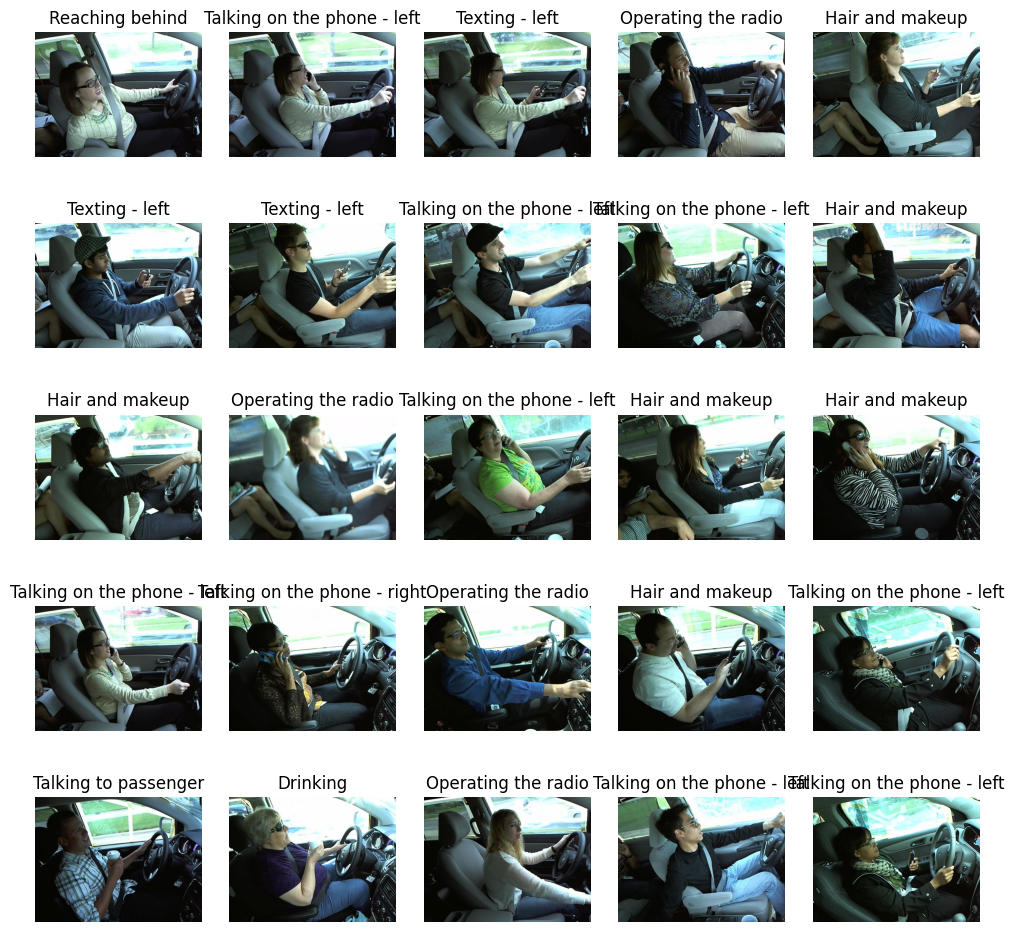

In [ ]:

test_path = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'
plt.figure(figsize=(10,10))
i = 1
for img_filename in os.listdir(test_path)[:25]:
    img_path = os.path.join(test_path, img_filename)
    img = tf.keras.utils.load_img(img_path)
    ax = plt.subplot(5, 5, i)
    plt.imshow(img)
    predicted_class_probs = predict_image(img_path)
    predicted_class_index = np.argmax(predicted_class_probs)
    predicted_activity = map[f'c{predicted_class_index}']  # Mapping predicted class index to activity
    plt.title(predicted_activity)
    plt.axis("off")
    i += 1
plt.tight_layout(pad=2.0)
plt.show()


In [ ]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("my_model.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("my_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
import tensorflow as tf
import numpy as np

# Mapping dictionary
map = {
    'c0': 'Safe driving',
    'c1': 'Texting - right',
    'c2': 'Talking on the phone - right',
    'c3': 'Texting - left',
    'c4': 'Talking on the phone - left',
    'c5': 'Operating the radio',
    'c6': 'Drinking',
    'c7': 'Reaching behind',
    'c8': 'Hair and makeup',
    'c9': 'Talking to passenger'
}

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="my_model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define a function to predict a single image
def predict_single_image(image_path):
    # Preprocess the image
    img = tf.keras.utils.load_img(image_path, target_size=(100, 100))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model's expected input shape

    #print("Image Shape:", img_array.shape)  # Debugging: Print image shape

    # Set input tensor
    input_data = img_array.astype(input_details[0]['dtype'])
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(output_data)
    # Get the index of the highest probability
    predicted_class_index = np.argmax(output_data)

    # Get the predicted activity label from the mapping
    predicted_activity = map[f'c{predicted_class_index}']

    return predicted_activity


In [ ]:
# Test the function
test_image_path = '/content/img_99761.jpg'
predicted_activity = predict_single_image(test_image_path)
print("Predicted Activity:", predicted_activity)

[[0.09878912 0.07942989 0.08915145 0.09105786 0.10789928 0.1118011
  0.09894852 0.12271312 0.09940515 0.1008045 ]]
Predicted Activity: Reaching behind


In [ ]:
'''train whenever needed the saved model
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("my_model.h5")

# Compile and train the model again
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, epochs=5, validation_data=val_data)

In [ ]:
'''
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
'''
# Load the pre-trained ResNet-50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the pre-trained layers to prevent them from being trained again
base_model.trainable = True

# Create a new sequential model
model = Sequential()

# Add the pre-trained ResNet-50 model to the new sequential model
model.add(base_model)

# Add additional layers on top of the ResNet-50 base model for fine-tuning
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['acc'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
#es = EarlyStopping(monitor='val_acc', min_delta=0.03, patience=3)

In [ ]:
#history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[es])

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 158s 611ms/step - acc: 0.1091 - loss: 22.6152 - val_acc: 0.1015 - val_loss: 1280.0011
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 77s 409ms/step - acc: 0.1446 - loss: 2.2411 - val_acc: 0.0923 - val_loss: 5.2892
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 77s 378ms/step - acc: 0.1529 - loss: 2.1985 - val_acc: 0.1227 - val_loss: 2.2663
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 383ms/step - acc: 0.1546 - loss: 2.1963 - val_acc: 0.1452 - val_loss: 2.2224
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 378ms/step - acc: 0.1497 - loss: 2.2070 - val_acc: 0.1401 - val_loss: 2.2211
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 384ms/step - acc: 0.1507 - loss: 2.1956 - val_acc: 0.1459 - val_loss: 2.1962
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 378ms/step - acc: 0.1472 - loss: 2.1957 - val_acc: 0.1456 - val_loss: 2.1944


In [ ]:
#history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es])

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 304ms/step - acc: 0.6084 - loss: 1.0572 - val_acc: 0.7727 - val_loss: 0.6917
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step - acc: 0.6156 - loss: 1.0728 - val_acc: 0.7687 - val_loss: 0.6815
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 252ms/step - acc: 0.6100 - loss: 1.0660 - val_acc: 0.8350 - val_loss: 0.5888


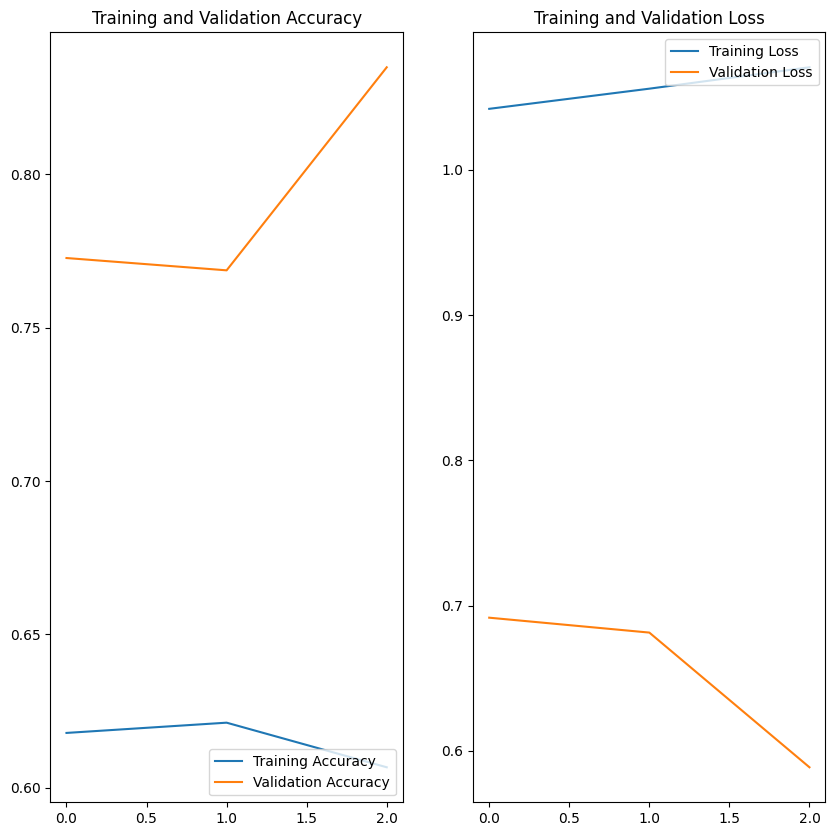

In [ ]:
'''
# visualizing accuracy and losses
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
'''
# function for predicting images
def predict_image(path):
    img = tf.keras.utils.load_img(path).resize((100,100))
    img = np.array(img).reshape((1,100,100,3))
    y = model.predict(img,verbose=False)
    return y

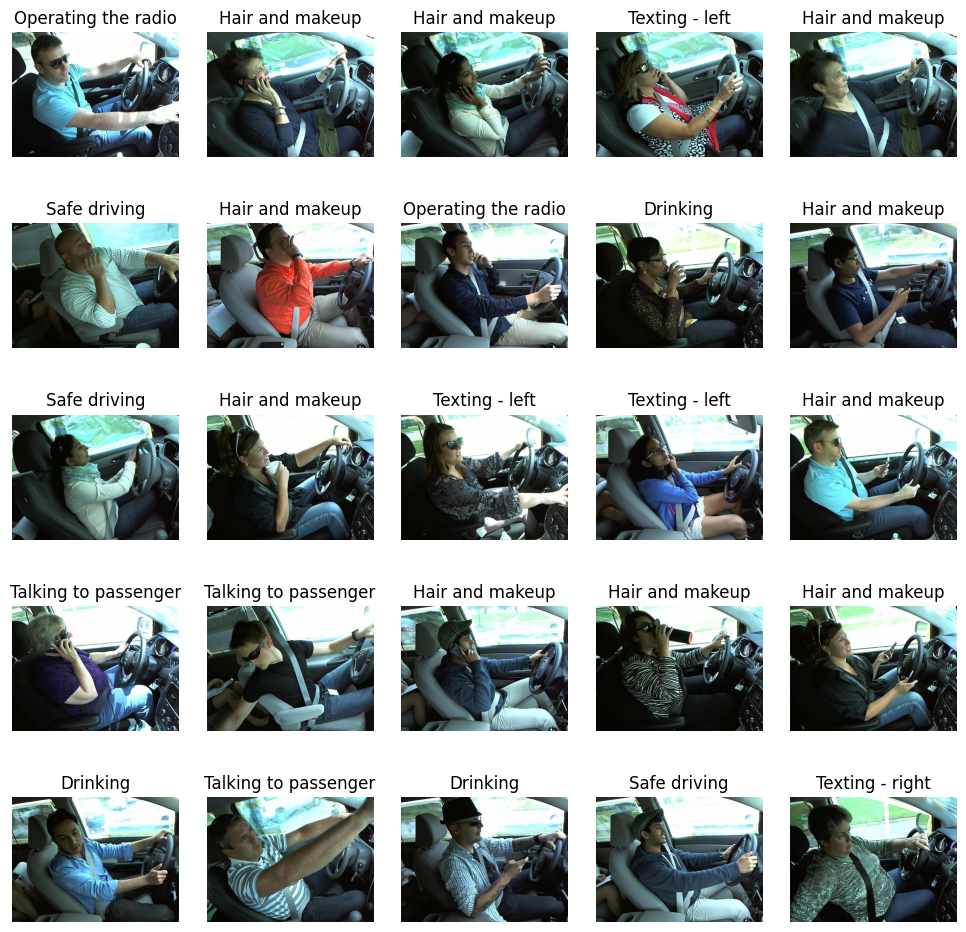

In [ ]:
'''
test_path = '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'
plt.figure(figsize=(10,10))
i = 1
for img_filename in os.listdir(test_path)[:25]:
    img_path = os.path.join(test_path, img_filename)
    img = tf.keras.utils.load_img(img_path)
    ax = plt.subplot(5, 5, i)
    plt.imshow(img)
    predicted_class_probs = predict_image(img_path)
    predicted_class_index = np.argmax(predicted_class_probs)
    predicted_activity = map[f'c{predicted_class_index}']  # Mapping predicted class index to activity
    plt.title(predicted_activity)
    plt.axis("off")
    i += 1
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
#model.save("model.h5")

In [ ]:
'''
import tensorflow as tf

# Save the model in SavedModel format
model.save("saved_model")

# Load the SavedModel
loaded_model = tf.keras.models.load_model("saved_model")

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


In [ ]:
'''
# Load the SavedModel
loaded_model = tf.keras.models.load_model("saved_model")

# Convert the model to TFLite format with optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

# Save the optimized TFLite model to a file
with open("optimized_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
'''
!pip install tensorflowjs
!tensorflowjs_converter \
    --input_format=keras \
    model.h5 \
    /tmp/my_tfjs_model


print(f"Test Accuracy: {test_accuracy * 100:.2f}%")